In [1]:
import os
import glob
import datetime
import cftime
from collections import Counter
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import genextreme as gev
from pyextremes import EVA

from unseen import fileio
from unseen import time_utils
from unseen import indices
from unseen import general_utils

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Parameters
dpi = 300

In [3]:
# Parameters
shapefile = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
metadata_file = "/home/599/dbi599/unseen/config/dataset_agcd_daily.yml"
rx15day_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
region_name = "east-coast-flood-region"
nino_file = "/home/599/dbi599/east-coast-rain/nino34.txt"


In [4]:
assert os.path.isfile(metadata_file), "Must provide a metadata file (papermill option -p metadata_file [filepath])"
assert os.path.isfile(shapefile), "Must provide a shapefile (papermill option -p shapefile [filepath])"
assert os.path.isfile(nino_file), "Must provide a Nino 3.4 file (papermill option -p nino_file [filepath])"
assert 'rx15day_file' in locals(), "Must provide an rx15day output file (papermill option -p rx15day_file [filepath])"
assert 'region_name' in locals(), "Must provide a region name (papermill option -p region_name [name])"

## Spatially aggregated data

In [5]:
agcd_files = glob.glob('/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_*_daily.nc')
agcd_files.sort()

In [6]:
ds_list = []
for infile in agcd_files:
    print(infile)
    ds = fileio.open_dataset(
        infile,
        metadata_file=metadata_file,
        shapefile=shapefile,
        variables=['pr'],
        spatial_agg='mean', 
    )
    ds = ds.compute()
    ds_list.append(ds)

/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19000101-19001231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19010101-19011231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19020101-19021231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19030101-19031231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19040101-19041231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19050101-19051231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19060101-19061231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19070101-19071231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19080101-19081231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19090101-19091231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_1910

/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19890101-19891231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19900101-19901231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19910101-19911231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19920101-19921231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19930101-19931231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19940101-19941231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19950101-19951231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19960101-19961231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19970101-19971231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19980101-19981231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_1999

In [7]:
ds = xr.concat(ds_list, dim='time')

In [8]:
ds

<xarray.Dataset>
Dimensions:  (time: 44655)
Coordinates:
  * time     (time) object 1900-01-01 09:00:00 ... 2022-04-05 09:00:00
Data variables:
    pr       (time) float32 2.563 0.275 0.1135 0.3795 ... 1.334 7.708 0.7992
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [9]:
ds = ds.compute()

In [10]:
ds_monthly_totals = ds.resample({'time': 'M'}).sum('time', keep_attrs=True)
ds_monthly_totals

<xarray.Dataset>
Dimensions:  (time: 1468)
Coordinates:
  * time     (time) object 1900-01-31 00:00:00 ... 2022-04-30 00:00:00
Data variables:
    pr       (time) float32 70.37 57.06 83.3 64.27 ... 166.4 316.7 326.6 15.97
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [11]:
ds_monthly_clim = ds_monthly_totals.groupby('time.month').mean('time', keep_attrs=True)
ds_monthly_clim

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    pr       (month) float32 120.4 126.7 121.9 83.53 ... 48.98 71.88 84.8 103.9
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

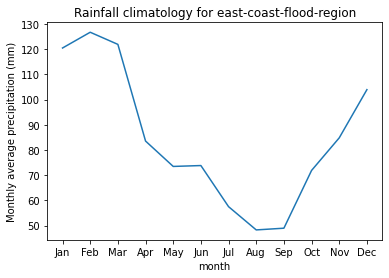

In [12]:
ds_monthly_clim['pr'].plot()
plt.ylabel('Monthly average precipitation (mm)')
plt.title(f'Rainfall climatology for {region_name}')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.show()

## Calculate rx15day

In [13]:
def str_to_cftime(datestring, cftime_type):
    """Convert a date string to cftime object"""

    dt = datetime.datetime.strptime(datestring, "%Y-%m-%d")
    cfdt = cftime_type(dt.year, dt.month, dt.day)

    return cfdt


def calc_rx15day(ds):
    """Calculate rx15day values and event dates"""
    
    ds_15day = ds.rolling({'time': 15}).sum(keep_attrs=True)

    ds_rx15day = time_utils.temporal_aggregation(ds_15day, 'A-AUG', 'D', 'max', ['pr'])
    cftime_type = type(ds_rx15day['time'].values[0])

    ds_rx15day_argmax = ds_15day.resample(time='A-AUG', label='left', loffset=datetime.timedelta(days=1)).reduce(np.nanargmax, dim='time')
    time_diffs = ds_rx15day_argmax['pr'].values.astype('timedelta64[D]')
    str_times = [time.strftime("%Y-%m-%d") for time in ds_rx15day_argmax['time'].values]
    event_datetimes_np = np.array(str_times, dtype='datetime64') + time_diffs
    event_datetimes_str = np.datetime_as_string(event_datetimes_np)
    event_datetimes_cftime = [str_to_cftime(time, cftime_type) for time in event_datetimes_str]
    ds_rx15day = ds_rx15day.assign(event_time=event_datetimes_cftime)
    
    return ds_rx15day

In [14]:
ds_rx15day = calc_rx15day(ds)

In [17]:
ds_rx15day

<xarray.Dataset>
Dimensions:     (time: 123, event_time: 123)
Coordinates:
  * time        (time) object 1900-08-31 00:00:00 ... 2022-08-31 00:00:00
  * event_time  (event_time) object 1900-01-26 00:00:00 ... 2022-03-09 00:00:00
Data variables:
    pr          (time) float64 158.6 152.0 108.9 111.8 ... 288.8 288.9 410.7
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [15]:
#time_stamp = datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y")
#ds_rx15day.attrs['history'] = f'{time_stamp}: /home/599/dbi599/east-coast-rain/AGCD_{region_name}.ipynb (git@github.com:AusClimateService/east-coast-rain)'
#fileio.to_zarr(ds_rx15day, rx15day_file)

## Analyse and plot Rx15day data

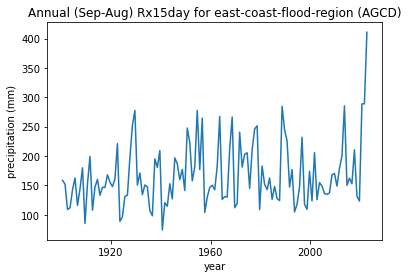

In [15]:
ds_rx15day['pr'].plot()
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} (AGCD)')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timeseries_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [19]:
#years = ds_rx15day['time'].dt.year.values
dates = [time.strftime("%Y-%m-%d") for time in ds_rx15day['event_time'].values]
df_rx15day = pd.DataFrame(index=dates)
df_rx15day['pr'] = ds_rx15day['pr'].values

In [20]:
df_rx15day['pr'].sort_values(ascending=False).head(n=10)

2022-03-09    410.744690
2021-03-24    288.879272
2020-02-19    288.798248
2013-03-04    285.407562
1988-04-14    284.566711
1954-02-23    277.744873
1929-02-20    277.528351
1963-05-09    267.536987
1968-01-18    266.335815
1956-02-20    264.522156
Name: pr, dtype: float64

In [21]:
rx15day_max = df_rx15day['pr'].values.max()
print(rx15day_max)

410.74468994140625


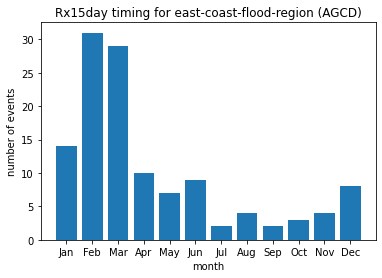

In [20]:
event_months = ds_rx15day['event_time'].dt.month.values
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} (AGCD)')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(xticks, xlabels)
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

Nino3.4 anomaly downloaded from: https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino34/

In [21]:
nino34_df = pd.read_csv(
    nino_file,
    header=None,
    skipfooter=7,
    skiprows=1,
    delim_whitespace=True,
    index_col=0,
    names=['year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
)
nino34_df

<ipython-input-21-eda0926a2225>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  nino34_df = pd.read_csv(


,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1870,-1.00,-0.95,-1.18,-1.35,-1.00,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...
2018,-0.86,-0.73,-0.73,-0.36,-0.12,0.12,0.27,0.05,0.30,0.84,1.00,0.97
2019,0.51,0.62,0.81,0.67,0.61,0.66,0.41,0.19,0.11,0.55,0.74,0.51
2020,0.64,0.48,0.36,0.49,-0.12,-0.21,-0.04,-0.42,-0.66,-1.19,-1.01,-0.98


In [22]:
event_months = ds_rx15day['event_time'].dt.month.values
event_years = ds_rx15day['event_time'].dt.year.values
event_nino34 = []
for month, year in zip(event_months, event_years):
     event_nino34.append(nino34_df.loc[nino34_df.index == year][month].values[0])
event_nino34 = np.array(event_nino34)
event_nino34

array([ 1.41,  0.05, -0.3 ,  0.29, -0.72,  0.29, -0.37, -0.43,  0.07,
       -0.54, -0.93, -0.57, -0.1 , -0.28,  0.32,  0.88, -0.63, -1.64,
       -0.43,  0.9 ,  0.64, -0.01, -0.54, -0.38,  0.63, -0.18,  1.19,
        0.23,  0.21, -0.08,  0.27,  1.33, -0.28, -0.21, -0.42, -0.19,
        0.74,  0.25,  0.23, -0.85,  1.19,  1.39,  0.53, -0.36, -0.42,
       -0.59, -0.48, -0.13,  0.18, -0.55, -0.86, -1.13, -0.42,  0.22,
        0.21, -0.8 , -0.98, -0.24,  1.4 ,  0.5 , -0.17, -0.1 , -0.29,
       -0.  , -0.53,  1.25,  1.45, -0.12, -0.6 ,  1.02,  0.75, -1.28,
       -0.58,  1.77, -1.44, -0.59, -0.68,  0.4 ,  0.06,  0.09,  0.13,
       -0.45, -0.02,  1.12, -0.6 , -1.18, -0.64,  1.24, -0.49, -1.11,
        0.36,  0.65,  1.62,  0.04, -0.06,  0.87, -0.4 , -0.24, -0.83,
       -1.41, -1.26, -0.63,  0.  ,  0.48, -0.1 , -0.01, -0.98, -0.16,
       -1.7 , -0.71,  1.18, -1.7 , -0.61, -0.14,  0.28,  1.04,  0.06,
       -0.09, -0.73,  0.84,  0.48, -0.72, -0.84])

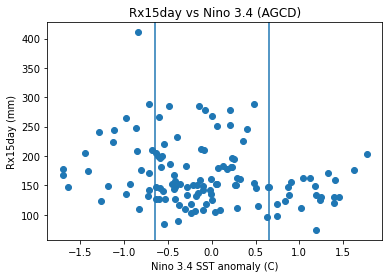

In [23]:
plt.scatter(event_nino34, ds_rx15day['pr'].values)
plt.title(f'Rx15day vs Nino 3.4 (AGCD)')
plt.ylabel('Rx15day (mm)')
plt.xlabel('Nino 3.4 SST anomaly (C)')
plt.axvline(0.65)
plt.axvline(-0.65)
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_ENSO_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [46]:
def gev_analysis(ds, event, region, savefig=False):
    """Perform GEV analysis
    
    Args:
      ds (Pandas Series): Data sample
      event (float) : Event of interest
      region (str) : Name of spatial region
    """

    gev_shape, gev_loc, gev_scale = indices.fit_gev(ds.values)
    print(f'Shape parameter: {gev_shape:.2f}')
    print(f'Location parameter: {gev_loc:.2f}')
    print(f'Scale parameter: {gev_scale:.2f}')

    fig, ax = plt.subplots(figsize=[10, 8])
    gev_xvals = np.arange(0, 700)
    ds.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
    gev_pdf = gev.pdf(gev_xvals, gev_shape, gev_loc, gev_scale)
    plt.plot(gev_xvals, gev_pdf, color='tab:green', linewidth=4.0)
    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Annual (Sep-Aug) Rx15day for {region} (AGCD)')
    if savefig:
        plt.savefig(
            f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_AGCD_{region}.png',
            bbox_inches='tight',
            facecolor='white',
            dpi=dpi
        )
    plt.show()
    
    event_probability = gev.sf(event, gev_shape, loc=gev_loc, scale=gev_scale)
    event_return_period = 1. / event_probability
    event_percentile = (1 - event_probability) * 100
    print(f'{event_return_period:.0f} year return period\n')
    print(f'{event_percentile:.2f}% percentile')
    
    return event_return_period

Shape parameter: -0.06
Location parameter: 142.63
Scale parameter: 38.90


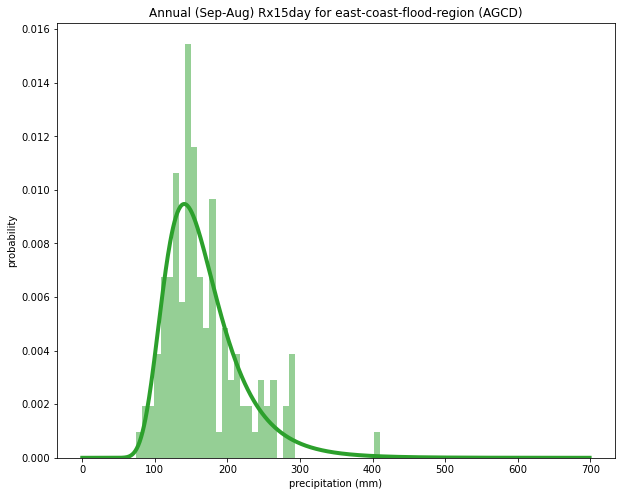

330 year return period

99.70% percentile


In [47]:
full_return_period = gev_analysis(df_rx15day['pr'], rx15day_max, region_name, savefig=True)

Shape parameter: -0.01
Location parameter: 142.84
Scale parameter: 38.34


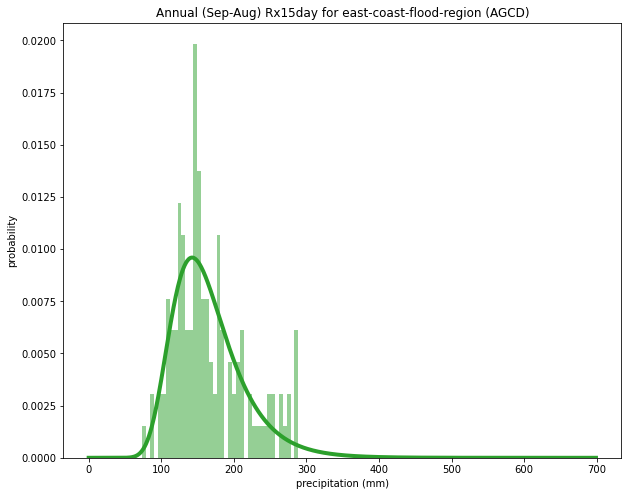

875 year return period

99.89% percentile


In [48]:
no2022_return_period = gev_analysis(df_rx15day['pr'][:-1], rx15day_max, region_name)

## Uncertainty analysis

In [43]:
ds_15day = ds.rolling({'time': 15}).sum(keep_attrs=True)
str_times = [time.strftime('%Y-%m-%d') for time in ds_15day['time'].values]
series_15day = pd.Series(data=ds_15day['pr'].values, index=pd.to_datetime(str_times))

In [44]:
series_15day[243:]

1900-09-01     11.184569
1900-09-02     11.836945
1900-09-03     12.063501
1900-09-04     12.763927
1900-09-05     13.231481
                 ...    
2022-04-01    135.274094
2022-04-02    135.173264
2022-04-03    132.629929
2022-04-04    137.195099
2022-04-05    137.774551
Length: 44412, dtype: float32

# The most extreme days
date-time
2018-03-07    131.542221
2018-10-19    123.290359
2020-02-19    288.798248
2021-03-24    288.879272
2022-03-09    410.744690
Name: extreme values, dtype: float64
               return value    lower ci    upper ci
return period                                      
5.000000         203.811585  189.064895  218.208205
10.000000        236.572143  215.993925  259.876669
20.000000        269.390891  241.159658  305.667051
50.000000        313.996588  271.261500  380.638771
100.000000       349.068367  292.230593  456.238313
330.134982       412.710108  329.990916  618.185484


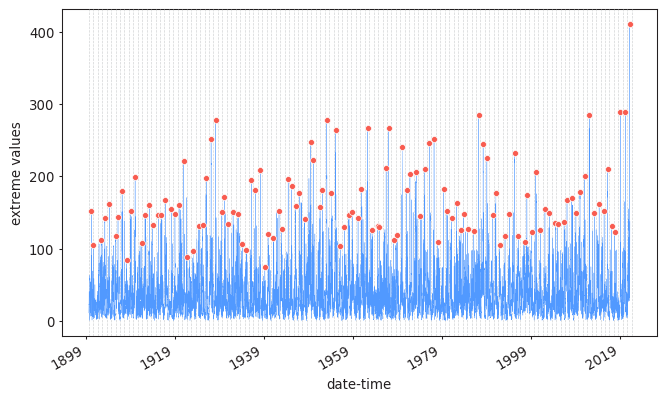

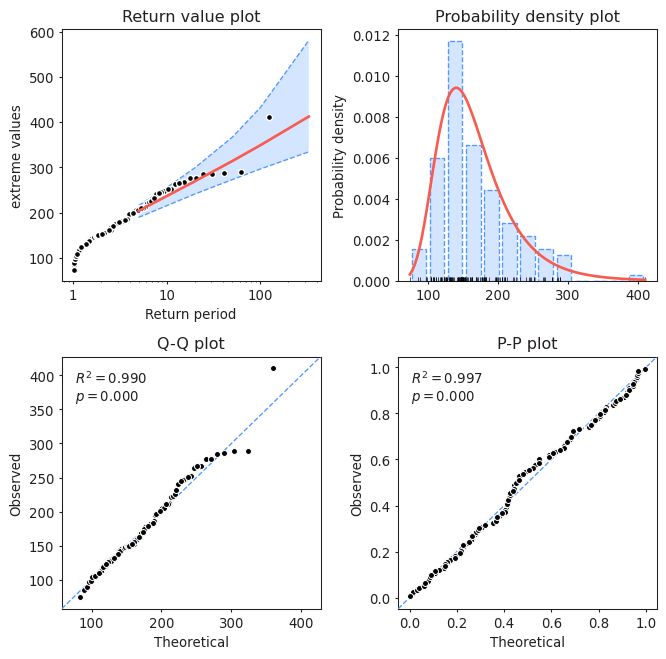

In [49]:
model = EVA(series_15day[243:])
model.get_extremes(method='BM', block_size='365.2425D')
print('# The most extreme days')
print(model.extremes.tail())
full_timeseries_fig, ax = model.plot_extremes()
model.fit_model(distribution='genextreme')    
summary = model.get_summary(
    return_period=[5, 10, 20, 50, 100, full_return_period],
    alpha=0.95,
    n_samples=1000
)
print(summary)
diagnostic_fig, ax = model.plot_diagnostic(alpha=0.95, return_period=[5, 10, 20, 50, 100, full_return_period])

## Test

In [60]:
rx15day_times = [time.strftime('%Y-%m-%d') for time in ds_rx15day['time'].values]
rx15day_series = pd.Series(data=ds_rx15day['pr'].values, index=pd.to_datetime(rx15day_times))

In [61]:
rx15day_series

1900-08-31    158.645004
1901-08-31    152.005112
1902-08-31    108.912323
1903-08-31    111.839317
1904-08-31    142.444809
                 ...    
2018-08-31    131.542221
2019-08-31    123.290359
2020-08-31    288.798248
2021-08-31    288.879272
2022-08-31    410.744690
Length: 123, dtype: float64

In [62]:
from pyextremes import models

In [65]:
test_model = models.get_model('MLE', rx15day_series, 'genextreme')

In [68]:
print(test_model)

                     MLE model                      
----------------------------------------------------
free parameters: c=-0.058, loc=142.630, scale=38.900
fixed parameters: all parameters are free           
AIC: 1303.492                                       
loglikelihood: -648.645                             
return value cache size: 0                          
fit parameter cache size: 0                         
----------------------------------------------------


In [69]:
type(test_model)

pyextremes.models.model_mle.MLE

In [66]:
test_summary = test_model.get_summary(
    return_period=[5, 10, 20, 50, 100, full_return_period],
    alpha=0.95,
    n_samples=1000
)
print(test_summary)

AttributeError: 'MLE' object has no attribute 'get_summary'